In [78]:
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import save_image
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [79]:
torch.manual_seed(0)
np.random.seed(0)

In [2]:
from timeit import default_timer
from collections import defaultdict
from tqdm import trange

class Trainer():
    def __init__(self, model, optimizer, loss_f, device, save_dir="results", is_progress_bar=True):
            self.device = device
            self.model = model.to(device)
            self.loss_f = loss_f
            self.optimizer = optimizer
            self.save_dir = save_dir
            self.is_progress_bar = is_progress_bar
            
    def __call__(self, data_loader, epochs=10, checkpoint_every=10):
        start = default_timer()
        self.model.train()
        for epoch in range(epochs):
            storer = defaultdict(list)
            mean_epoch_loss = self._train_epoch(data_loader, storer, epoch)
            mean_epoch_loss = self._test_epoch(data_loader, storer, epoch)
            with torch.no_grad():
                sample = torch.randn(64, self.model.latent_dim).to(device)
                sample = self.model.decoder(sample).cpu()  # make sure on cpu
                save_image(sample.view(64, 1, 32, 32),
                           './results/samples/' + str(epoch) + '.png')
            
    def _train_epoch(self, data_loader, storer, epoch):
        epoch_loss = 0.
        kwargs = dict(desc="Epoch {}".format(epoch + 1), leave=False,
                      disable=not self.is_progress_bar)
        with trange(len(data_loader), **kwargs) as t:
            for _, (data, _) in enumerate(data_loader):
                iter_loss = self._train_iteration(data, storer)
                epoch_loss += iter_loss
                t.set_postfix(loss=iter_loss)
                t.update()
        mean_epoch_loss = epoch_loss / len(data_loader)
        return mean_epoch_loss
    
    def _train_iteration(self, data, storer):
        batch_size, channel, height, width = data.size()
        data = data.to(self.device)
        recon_batch, latent_dist, latent_sample = self.model(data)
        loss = self.loss_f(data, recon_batch, latent_dist, self.model.training, 
                           storer, latent_sample=latent_sample)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
            
        return loss.item()
    
    def _test_epoch(self, data_loader, storer, epoch):
        epoch_loss = 0.
        kwargs = dict(desc="Epoch {}".format(epoch + 1), leave=False,
                      disable=not self.is_progress_bar)
        with trange(len(data_loader), **kwargs) as t:
            for _, (data, _) in enumerate(data_loader):
                iter_loss = self._train_iteration(data, storer)
                epoch_loss += iter_loss
                t.set_postfix(loss=iter_loss)
                t.update()
        mean_epoch_loss = epoch_loss / len(data_loader)
        return mean_epoch_loss
    
    def _test_iteration(self, data, storer):
        batch_size, channel, height, width = data.size()
        data = data.to(self.device)
        recon_batch, latent_dist, latent_sample = self.model(data)
        loss = self.loss_f(data, recon_batch, latent_dist, self.model.training, 
                               storer, latent_sample=latent_sample)
            
        return loss.item()

In [3]:
LOSSES = ["betaH", "betaB"]
RECON_DIST = ["bernoulli", "laplace", "gaussian"]

In [4]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size = 64

mnist_dataset = datasets.MNIST('../../data', 
                   train=True, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

mnist_dataset_test = datasets.MNIST('../../data', train=False, download=True, transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
from vae import VAE
from encoder import Encoder
from decoder import Decoder
from losses import get_loss_fn
from torch import optim

latent_dim = 12
img_size = [1,32,32]

lr = 5e-4

betaB_args = {"rec_dist": "bernoulli",
              "reg_anneal": 10000, 
              "betaH_B": 4,
              "betaB_initC": 0,
              "betaB_finC": 25,
              "betaB_G": 100
             }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_f = get_loss_fn("betaB", n_data=len(train_loader.dataset), device=device, **betaB_args)

encoder = Encoder(img_size, latent_dim)
decoder = Decoder(img_size, latent_dim)

generator_model = VAE(img_size, latent_dim, encoder, decoder).to(device)
optimizer = optim.Adam(generator_model.parameters(), lr=lr)

In [7]:
generator_model.load_state_dict(torch.load('test.pt'))
# torch.save(trainer.model.state_dict(), 'test.pt')

<All keys matched successfully>

In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

classifier = Classifier()
classifier.load_state_dict(torch.load('mnist_cnn.pt'))

<All keys matched successfully>

In [9]:
class AddNoise():
    def __init__(self, shape, device, noise=None, percent_noise=0.1):
        self.device = device
        self.percent_noise = percent_noise
        if noise is None:
            self.noise = torch.randn(shape)
        else:
            self.noise = noise

    def noisy(self, data):
        x = self.noise.to(self.device) * self.percent_noise + data * (1 - self.percent_noise)
        return x

In [229]:
sample_noise = torch.zeros(torch.Size([1, 12]))

In [240]:
sample_noise[0,4] = torch.tensor(-1)
sample_noise[0,5] = torch.tensor(-10)
sample_noise[0,6] = torch.tensor(-51)
sample_noise

tensor([[  0.,   0.,   0.,   0.,  -1., -10., -51.,   0.,   0.,   0.,   0.,   0.]])

tensor(1)


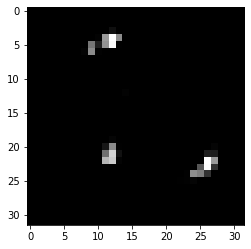

In [241]:
recon_img = generator_model.decoder(0.912*sample_noise.cuda())
plt.imshow(recon_img[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
print(torch.argmax(classifier(F.upsample(recon_img, (28,28), mode='bilinear', align_corners=True).cpu())))

In [23]:
# i = 8
# recon_img,l_dist,l_sample = generator_model(torch.FloatTensor(example_data[i]).unsqueeze(0).to(device))
# print(l_sample.shape)
# noise = AddNoise(l_sample.shape, device, sample_noise, percent_noise=0.45)

# l_sample_noised = noise.noisy(l_sample)

# recon_noised = generator_model.decoder(l_sample_noised)

# plt.imshow(recon_noised[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

# new_img_0 = F.upsample(recon_noised, (28,28), mode='bilinear')
# print(classifier(new_img_0.cpu()))
# torch.argmax(classifier(new_img_0.cpu()))

In [41]:
# plt.figure(figsize=(10,10))
# plt.subplot(1,3,1)
# plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
# plt.title("{} -> {}".format(example_targets[i].item(), torch.argmax(classifier(F.upsample(example_data[i].unsqueeze(0), (28,28), mode='bilinear').cpu())).item()))
# plt.subplot(1,3,2)
# plt.imshow(recon_img[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
# plt.title("{} -> {}".format(example_targets[i].item(), torch.argmax(classifier(F.upsample(recon_img, (28,28), mode='bilinear').cpu())).item()))
# plt.subplot(1,3,3)
# plt.imshow(recon_noised[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
# plt.title("{} -> {}".format(example_targets[i].item(), torch.argmax(classifier(F.upsample(recon_noised, (28,28), mode='bilinear').cpu())).item()))

In [242]:
def evaluate(i, percentage, sample_noise=sample_noise):
    recon_img,l_dist,l_sample = generator_model(torch.FloatTensor(example_data[i]).unsqueeze(0).to(device))
    noise = AddNoise(l_sample.shape, device, sample_noise, percent_noise=percentage)
    l_sample_noised = noise.noisy(l_sample)
    recon_noised = generator_model.decoder(l_sample_noised)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title("{} -> {}".format(example_targets[i].item(), torch.argmax(classifier(F.upsample(example_data[i].unsqueeze(0), (28,28), mode='bilinear').cpu())).item()))
    plt.subplot(1,3,2)
    plt.imshow(recon_img[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title("{} -> {}".format(example_targets[i].item(), torch.argmax(classifier(F.upsample(recon_img, (28,28), mode='bilinear').cpu())).item()))
    plt.subplot(1,3,3)
    plt.imshow(recon_noised[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.title("{} -> {}".format(example_targets[i].item(), torch.argmax(classifier(F.upsample(recon_noised, (28,28), mode='bilinear').cpu())).item()))

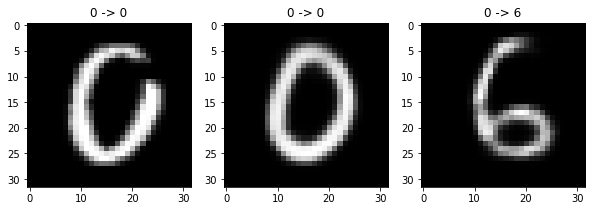

In [243]:
evaluate(9, 0.16)

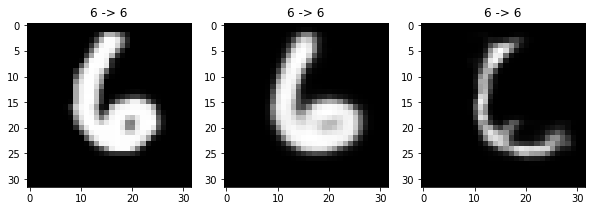

In [244]:
evaluate(8, 0.152)

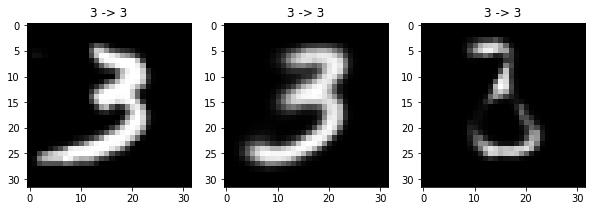

In [245]:
evaluate(18, 0.190)

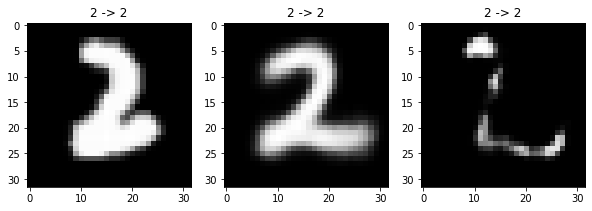

In [246]:
evaluate(11, 0.31)

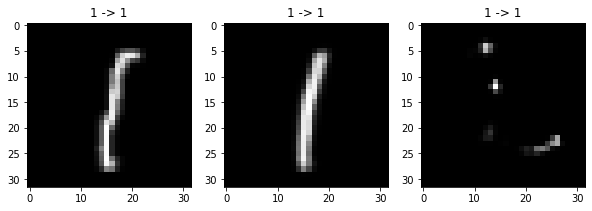

In [247]:
evaluate(13, 0.454)

In [173]:
# new_img_0 = F.upsample(recon_noised, (28,28), mode='bilinear')
# print(classifier(new_img_0.cpu()))
# torch.argmax(classifier(new_img_0.cpu()))

In [174]:
# new_img_1 = F.upsample(recon_img, (28,28), mode='bilinear')
# print(classifier(new_img_1.cpu()))
# torch.argmax(classifier(new_img_1.cpu()))

In [175]:
# new_img_2 = example_data[i].unsqueeze(0)
# new_img_2 = F.upsample(new_img_2, (28,28), mode='bilinear')
# torch.argmax(classifier(new_img_2.cpu()))